# Duration prediction 

In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt 
import math
from geopy import distance as geo


In [6]:
parse_dates = lambda x: dt.datetime.strftime(x, "%Y%M%D%H")

# import the df, zipcode and the weather data 
df = pd.read_csv(r"..\output_data\transform_DF", index_col=0)
df = pd.read_csv(r"..\output_data\transformed_full.csv", index_col=0)
weather = pd.read_csv(r"..\data\frankfurt_weather_data2019.csv", sep=",", index_col=0)
zc = pd.read_csv(r"..\geo_Data\backup_zipcodes.csv", index_col=0)

In [ ]:
# Take the basic df 
X_predictors = df 

# Create the predictor matrix columns that are not needed
# Create the predictor matrix columns that are not needed
X_predictors = X_predictors.drop(columns=["Start_Latitude"
        , "Bike_number"
        , "Start_Longitude"
        , "End_Station_number"
        , "End_time"
        , "End_Latitude"
        , "End_Longitude"
        , "Bikes_on_position"
        , "End_Bikes", "Start_Station"])

X_predictors["week"] = pd.to_datetime(df["Start_Time"]).dt.strftime('%w').astype(int)  
X_predictors["week_day"] = pd.to_datetime(df["Start_Time"]).dt.strftime('%u').astype(int)                    

In [232]:
# Format date to other format "2019-20-01 00:00:00 to 2019200100"
X_predictors["date"] = X_predictors["Start_Time"].astype(str).str.replace("-","")
X_predictors["date"] = X_predictors["date"].str.replace(":*:.*","")
X_predictors["date"] = X_predictors["date"].str.replace("\s","")

# Create intervalls for hours
X_predictors["hour"] = X_predictors["date"].astype(str).str.extract("([0-9]{2}$)")
X_predictors["month"] = X_predictors["date"].str.replace("([0-9]{4}$)","")

# create month feature  
X_predictors["month"] = X_predictors["month"].astype(str).str.extract("([0-9]{2}$)")

X_predictors["EVENING"] = ((X_predictors["hour"] > "18") | (X_predictors["hour"] == "00"))
X_predictors["MIDDAY"] = ((X_predictors["hour"] > "12") & (X_predictors["hour"] <= "18"))
X_predictors["MORNING"] = ((X_predictors["hour"] > "06") & (X_predictors["hour"] <= "12"))
X_predictors["NIGHT"] = ((X_predictors["hour"] > "00") & (X_predictors["hour"] < "07"))

X_predictors["EVENING"] = pd.to_numeric(X_predictors["EVENING"]).astype(int)
X_predictors["MIDDAY"] = pd.to_numeric(X_predictors["MIDDAY"]).astype(int)
X_predictors["MORNING"] = pd.to_numeric(X_predictors["MORNING"]).astype(int)
X_predictors["NIGHT"] = pd.to_numeric(X_predictors["NIGHT"]).astype(int)

In [233]:
# calculate durantion between center point of downtown and not used in model
down_town = pd.DataFrame(data=[["point A", 8.683319091796875, 50.110285930959314]],
                                columns=["Describtion", "long", "latitude"])
distance_DT = pd.Series(index=df.index, data=list(map(
        lambda x: geo.distance(tuple(down_town.loc[0]["long":"latitude"]),
                               tuple((df.loc[x]["Start_Longitude"], df.loc[x]["Start_Latitude"]))).km, df.index)))
X_predictors["Distan_DT"] = distance_DT    

In [234]:
    # create average hourly duration 
    # format date for hour
    X_predictors["Start_Time_tem"] = pd.to_datetime(X_predictors["date"], format=("%Y%m%d%H"))
    X_predictors["Duration"] = X_predictors["Duration"].astype(float)
    hours = X_predictors.groupby("Start_Time_tem")["Duration"].mean()
    hours = pd.DataFrame(hours)
    count = 0
    hours

,Duration
Start_Time_tem,
2019-01-20 00:00:00,21.666667
2019-01-20 03:00:00,12.000000
2019-01-20 08:00:00,25.000000
2019-01-20 09:00:00,17.000000
2019-01-20 10:00:00,26.000000
...,...
2019-12-31 17:00:00,10.333333
2019-12-31 18:00:00,12.000000
2019-12-31 19:00:00,16.166667


In [235]:
count = 0
# create the hourly averages of the last 4 hours before booking
for i in X_predictors.index:
        
        try:
            count+=1
            X_predictors.loc[i,"H1"] = hours.loc[X_predictors.loc[i,"Start_Time_tem"]- dt.timedelta(hours=1)]["Duration"]
          
        except KeyError :
             continue
            
        try:
            X_predictors.loc[i,"H2"] = hours.loc[X_predictors.loc[i,"Start_Time_tem"]- dt.timedelta(hours=2)]["Duration"]
         
        except KeyError :
             continue
        try:
            X_predictors.loc[i,"H3"] = hours.loc[X_predictors.loc[i,"Start_Time_tem"]- dt.timedelta(hours=3)]["Duration"]
         
           
        except KeyError :
            continue
        try:
            X_predictors.loc[i,"H4"] = hours.loc[X_predictors.loc[i,"Start_Time_tem"]- dt.timedelta(hours=4)]["Duration"]
        except KeyError :
            continue
           
       

In [236]:
# Use zip code for border districts
X_predictors["Borderdistrict"] = X_predictors["Zip_codes"].isin([65929, 60529, 60549, 65931, 65936, 60528, 60388, 60437, 60438, 60439,
                                                 60433, 60598, 60599, 63067, 60314, 60386]).astype(int)


In [237]:
# set temp to datetype string
weather.index = weather.index.astype(str)

#Join weather dates to predictor matrix 
X_predictors = X_predictors.join(weather, on="date" ,how="inner")

# Set weekday from boolean to int 
X_predictors["Weekday"] = X_predictors["Weekday"].astype(int)

# drop not needed weather data 
X_predictors.drop(columns=["relative humidity","Rainfall","SD_SO","V_VV"], inplace=True)


In [238]:
# create the dates for all days in data set 
start = dt.datetime(2019,1,20)
dates = pd.date_range(start=start, end=dt.datetime(2019,12,31), periods=346)

dates

# set series 
median = pd.Series(index = dates, data = 0)



count = 0
for i in range(0,346):
    start = dates[count]
    
    if i == 345:
        mean.loc[dates[count]] = df[(pd.to_datetime(df["Start_Time"]) >= dates[345])]["Duration"].describe()[1] 
        break;
    
    end = dates[count+1]
    #median.loc[dates[count]] = df[(pd.to_datetime(df["Start_Time"]) >= start) & (pd.to_datetime(df["Start_Time"]) < end)]["Duration"].describe()[4]
    mean.loc[dates[count]] = df[(pd.to_datetime(df["Start_Time"]) >= start) & (pd.to_datetime(df["Start_Time"]) < end)]["Duration"].describe()[1]               
    count+=1    



In [239]:
mean[345:]

2019-02-20 02:09:46.046511628    22.258427
2019-02-21 02:13:57.209302325    25.531915
2019-02-22 02:18:08.372093023    21.234783
2019-02-23 02:22:19.534883721    30.116667
2019-02-24 02:26:30.697674418    38.493333
                                   ...    
2019-07-27 00:00:00.000000000    22.924528
2019-07-28 00:00:00.000000000    30.033898
2019-07-29 00:00:00.000000000    21.873418
2019-07-30 00:00:00.000000000    23.210256
2019-07-31 00:00:00.000000000    21.359447
Length: 344, dtype: float64

In [240]:
# set values of average duration for last 4 days 
X_predictors["L1"] = pd.Series(index = df.index,data =list(map(lambda x :  mean.shift(1)[pd.to_datetime(pd.to_datetime(df.loc[x]["Start_Time"]).strftime("%Y-%m-%d"))], df.index)))
X_predictors["L2"] = pd.Series(index = df.index,data =list(map(lambda x :  mean.shift(2)[pd.to_datetime(pd.to_datetime(df.loc[x]["Start_Time"]).strftime("%Y-%m-%d"))], df.index)))


In [294]:
X_predictors 

,Start_Time,Weekday,Duration,EVENING,MIDDAY,MORNING,NIGHT,H1,H2,H3,H4,Borderdistrict,hourly temperatur,L1,L2
27,2019-05-30 15:42:00,1,100.0,0,1,0,0,19.875,30.4,43.696,27.818,1,20.1,25.377,24.247
22130,2019-05-30 15:43:00,1,97.0,0,1,0,0,19.875,30.4,43.696,27.818,1,20.1,25.377,24.247
32318,2019-05-30 15:42:00,1,26.0,0,1,0,0,19.875,30.4,43.696,27.818,0,20.1,25.377,24.247
45697,2019-05-30 15:05:00,1,11.0,0,1,0,0,19.875,30.4,43.696,27.818,0,20.1,25.377,24.247
59767,2019-05-30 15:06:00,1,22.0,0,1,0,0,19.875,30.4,43.696,27.818,0,20.1,25.377,24.247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176032,2019-12-25 12:13:00,1,10.0,0,0,1,0,9.500,11.5,0.000,0.000,0,8.2,15.556,22.299
176050,2019-02-14 02:06:00,1,23.0,0,0,0,1,0.000,0.0,0.000,0.000,0,0.9,19.205,21.171
176276,2019-07-26 04:53:00,1,17.0,0,0,0,1,22.000,48.0,13.000,11.500,0,24.6,23.151,22.225
176450,2019-04-08 00:27:00,1,6.0,1,0,0,0,15.000,0.0,0.000,0.000,0,13.6,32.891,29.786


In [247]:
temp

,Start_Time,Weekday,Duration,EVENING,MIDDAY,MORNING,NIGHT,Distan_DT,H1,H2,H3,H4,Borderdistrict,hourly temperatur,L1,L2
27,2019-05-30 15:42:00,1,100.0,0,1,0,0,14.395565,19.875,30.4,43.696,27.818,1,20.1,25.377,24.247
22130,2019-05-30 15:43:00,1,97.0,0,1,0,0,14.395565,19.875,30.4,43.696,27.818,1,20.1,25.377,24.247
32318,2019-05-30 15:42:00,1,26.0,0,1,0,0,2.686563,19.875,30.4,43.696,27.818,0,20.1,25.377,24.247
45697,2019-05-30 15:05:00,1,11.0,0,1,0,0,1.997864,19.875,30.4,43.696,27.818,0,20.1,25.377,24.247
59767,2019-05-30 15:06:00,1,22.0,0,1,0,0,0.922437,19.875,30.4,43.696,27.818,0,20.1,25.377,24.247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176032,2019-12-25 12:13:00,1,10.0,0,0,1,0,0.699120,9.500,11.5,0.000,0.000,0,8.2,15.556,22.299
176050,2019-02-14 02:06:00,1,23.0,0,0,0,1,0.982781,0.000,0.0,0.000,0.000,0,0.9,19.205,21.171
176276,2019-07-26 04:53:00,1,17.0,0,0,0,1,3.545299,22.000,48.0,13.000,11.500,0,24.6,23.151,22.225
176450,2019-04-08 00:27:00,1,6.0,1,0,0,0,1.746620,15.000,0.0,0.000,0.000,0,13.6,32.891,29.786


In [248]:
    # fillna and round to 3 decimal 
    X_predictors.fillna(value=0, inplace=True)
    X_predictors["L1"] = X_predictors["L1"].round(3)
    X_predictors["L2"] = X_predictors["L2"].round(3)
    X_predictors["H1"] = X_predictors["H1"].round(3)
    X_predictors["H2"] = X_predictors["H2"].round(3)
    X_predictors["H3"] = X_predictors["H3"].round(3)
    X_predictors["H4"] = X_predictors["H4"].round(3)
     
    
    

    # Drop duration from predictor
    X_predictors.drop(
        columns=["Distan_DT"],
        inplace=True)

    
    # split test and training set 
    x_test = X_predictors[(X_predictors["Start_Time"] <= "2019-07-31 23:59:00") & (X_predictors["Start_Time"] >= "2019-07-01 00:00:00")]
    x_train = X_predictors[(X_predictors["Start_Time"] > "2019-07-31 23:59:00") | (X_predictors["Start_Time"] < "2019-07-01 00:00:00")]
           
    # set target and preditor values
    y_test = x_test["Duration"]
    y_train = x_train["Duration"]
    
    #drop start_Time
    x_test.drop(columns=["Start_Time", "Duration"], inplace=True)
    x_train.drop(columns=["Start_Time", "Duration"], inplace=True)
     
    
    
    X_predictors.corr()

C:\Users\manue\miniconda3\envs\PDS20\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Weekday,Duration,EVENING,MIDDAY,MORNING,NIGHT,H1,H2,H3,H4,Borderdistrict,hourly temperatur,L1,L2
Weekday,1.000000,-0.074235,-0.025310,-0.025638,0.003273,0.068446,-0.157561,-0.170342,-0.178898,-0.174433,-0.044816,-0.120882,-0.101630,0.027985
Duration,-0.074235,1.000000,-0.071515,0.024153,0.069367,-0.057330,0.125221,0.103848,0.089466,0.072909,0.086711,0.108360,0.096541,0.065398
EVENING,-0.025310,-0.071515,1.000000,-0.384346,-0.299527,-0.150206,-0.124960,-0.037099,0.036232,0.097353,-0.028884,-0.060424,-0.011487,-0.022310
MIDDAY,-0.025638,0.024153,-0.384346,1.000000,-0.572054,-0.286872,0.133674,0.218282,0.305694,0.382948,0.014497,0.247846,0.024411,0.002723
MORNING,0.003273,0.069367,-0.299527,-0.572054,1.000000,-0.223564,0.084264,0.009856,-0.093436,-0.232414,0.010104,-0.112569,-0.017353,-0.002942
NIGHT,0.068446,-0.057330,-0.150206,-0.286872,-0.223564,1.000000,-0.193618,-0.327314,-0.403285,-0.392703,-0.003461,-0.159116,0.000806,0.027717
H1,-0.157561,0.125221,-0.124960,0.133674,0.084264,-0.193618,1.000000,0.343652,0.297292,0.263266,0.021918,0.279146,0.201491,0.147536
H2,-0.170342,0.103848,-0.037099,0.218282,0.009856,-0.327314,0.343652,1.000000,0.431922,0.395236,0.025141,0.320561,0.183324,0.149038
H3,-0.178898,0.089466,0.036232,0.305694,-0.093436,-0.403285,0.297292,0.431922,1.000000,0.527608,0.021708,0.351765,0.157753,0.110747
H4,-0.174433,0.072909,0.097353,0.382948,-0.232414,-0.392703,0.263266,0.395236,0.527608,1.000000,0.019192,0.363332,0.146908,0.097344


In [249]:
# save predictors and target data 
Y.to_csv("Y_target_vector.csv")
X_predictors.to_csv("X_predictor_matrix.csv")

# Linear regression

RMSE:  21.966076851057117
MAE:  12.961796350581347
r²:  0.054893715162938506


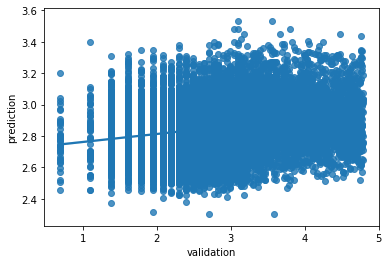

In [293]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics

x_train_va, x_test_va, y_train_va, y_test_va = train_test_split(x_train,y_train.apply(np.log) , test_size=0.3)

st_scaler = StandardScaler()


st_scaler.fit(x_train_va)
X_train_scaled = st_scaler.transform(x_train_va)

lin = LinearRegression()
lin.fit(X_train_scaled, y_train_va)


x_test_scaled_va = st_scaler.transform(x_test_va)
y_predict_val = lin.predict(x_test_scaled_va)


sns.regplot(y_test_va, y_predict_val)
plt.xlabel("validation")
plt.ylabel("prediction")
print("RMSE: ", np.sqrt(metrics.mean_squared_error(np.exp(y_test_va), np.exp(y_predict_val))))
print("MAE: ", metrics.mean_absolute_error(np.exp(y_test_va), np.exp(y_predict_val)))
print("r²: ", metrics.r2_score(y_test_va, y_predict_val))



Test set prdiction with trained model:

RMSE:  15.787657192213251
MAE:  15.59922825326094
r²:  0.015891948682956736


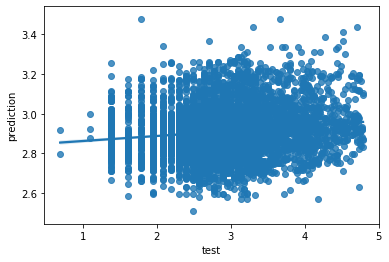

In [289]:

x_test_scaled = st_scaler.transform(x_test)

y_predict = lin.predict(x_test_scaled)

sns.regplot(y_test.apply(np.log), y_predict)
plt.xlabel("test")
plt.ylabel("prediction")
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test.apply(np.log), np.exp(y_predict))))
print("MAE: ", metrics.mean_absolute_error(y_test.apply(np.log), np.exp(y_predict)))
print("r²: ", metrics.r2_score(y_test.apply(np.log), y_predict))


In [278]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [279]:
x_train_va, x_test_va, y_train_va, y_test_va = train_test_split(x_train,y_train.apply(np.log) , test_size=0.3)
st_scaler = StandardScaler()


st_scaler.fit(X_train)
X_train_scaled = st_scaler.transform(X_train)




In [280]:
rs = RobustScaler()
poly = PolynomialFeatures()
lasso = Lasso()

pipe = Pipeline([
    ("poly", poly),
    ("robust", rs),
    ("lasso", lasso)
])

# Use estimator's give name with a double underscore to set parameters!
param_grid = {
    'poly__degree': [1,2],
    'lasso__alpha': np.linspace(0, 1, 5), # 0.0, 0.25, 0.5, 0.75, 1
}

In [281]:
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=True, n_jobs=4,
                    scoring="neg_root_mean_squared_error")

In [282]:
grid.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   31.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   34.0s finished
C:\Users\manue\miniconda3\envs\PDS20\lib\site-packages\sklearn\pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\manue\miniconda3\envs\PDS20\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\manue\miniconda3\envs\PDS20\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11137903.830031686, tolerance: 2341.537132115268
  positive)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('poly',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('robust',
                                        RobustScaler(copy=True,
                                                     quantile_range=(25.0,
                                                                     75.0),
                                                     with_centering=True,
                                                     with_scaling=True)),
                                       ('lasso',
                                        Lasso(alpha=1.0, copy_X=True,
                                     

In [283]:
grid_df = pd.DataFrame(grid.cv_results_["params"])
grid_df["loss"] = -grid.cv_results_['mean_test_score']
grid_df


y_pred = grid.predict(x_test)

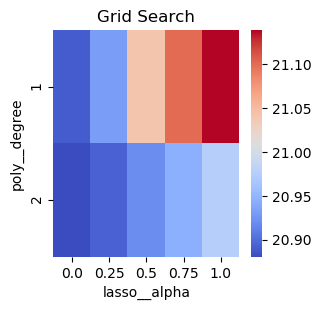

RMSE:  19.3149912210289
MAE:  13.397864604041178
r²:  0.03062772443776096


In [284]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=100)
sns.heatmap(grid_df.pivot(columns="lasso__alpha", values="loss", index="poly__degree"), cmap="coolwarm", ax=ax)
ax.set_title("Grid Search")

plt.show()
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))
print("r²: ", metrics.r2_score(y_test, y_pred))

# --------------------------------------------------------------

In [285]:
X_test_scaled = st_scaler.transform(X_test)
y_predict = lin.predict(X_test_scaled)



print("RMSE: ", np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_predict))))
print("MAE: ", metrics.mean_absolute_error(np.exp(y_test), np.exp(y_predict)))
print("r²: ", metrics.r2_score(y_test,y_predict))

C:\Users\manue\miniconda3\envs\PDS20\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


ValueError: Found input variables with inconsistent numbers of samples: [5397, 17037]

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from geopy import distance as geo
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_predictors, Y.apply(np.log), test_size = 0.3)





st_scaler = StandardScaler()
st_scaler.fit(X_train)
scaled_x_train = st_scaler.transform(X_train)

X_train

In [ ]:
# initialte nn with 5 inputs and hidden layer 
model = keras.Sequential(
            [layers.Dense(50, activation="sigmoid", input_shape=[X_train.shape[1]]),
            layers.Dropout(0.1),
            layers.Dense(50, activation="sigmoid", ),
            layers.Dropout(0.1),
            layers.Dense(50, activation="sigmoid"),
            layers.Dropout(0.1),
            layers.Dense(1)])
optimizer = keras.optimizers.Adam()
    
model.compile(loss='mse',
             optimizer=optimizer,
             metrics=["mae", "mse"])
print(scaled_x_train)

In [ ]:
model.fit(scaled_x_train, y_train.values, epochs=20, batch_size=500, validation_split=0.2)

In [ ]:
X_test_scaled = st_scaler.transform(X_test)
y_pred = model.predict(X_test_scaled)

In [ ]:
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))
print("r²: ", metrics.r2_score(y_test, y_pred))